In [ ]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [ ]:
torch.cuda.is_available()

False

In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.

        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        # obs_shape is the shape of a single observation -> use this information to define the dimensions of the layers
        super(DQN, self).__init__()

        # TODO: your code
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)

        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: your code
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        # As several students have not understood it this way, no points are deducted for missing the last activation
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out


In [ ]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [ ]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

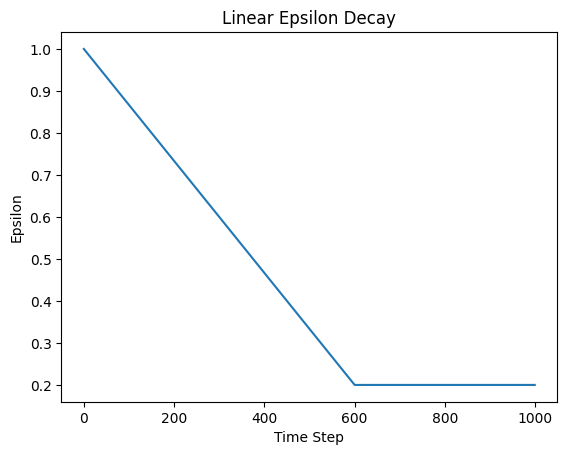

In [ ]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()


In [ ]:
test_input = torch.tensor([1, 2, 3, 4], dtype=torch.float32)

# Given a neural network
net = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)
print(f"Prediction (Before): {net(test_input)}\n")

# We can get its parameters with .state_dict(). A dictionary containing all the parameters.
# Note: It contains even more than parameters, but that is not relevant for us.
params = copy.deepcopy(net.state_dict())

print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Set weight matrix of first layer to zero
net[0].weight.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Load the old parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")


Prediction (Before): tensor([-0.1629], grad_fn=<ViewBackward0>)

Parameters:
- Parameter 0.weight:
tensor([[-0.2643, -0.2701, -0.4420, -0.3653],
        [-0.3261,  0.2318,  0.1557,  0.3576],
        [-0.2804,  0.4832, -0.1836, -0.3105]])
- Parameter 0.bias:
tensor([ 0.4991, -0.0665,  0.3937])
- Parameter 2.weight:
tensor([[-0.5738,  0.0328,  0.0716]])
- Parameter 2.bias:
tensor([-0.2274])

Prediction (After change): tensor([-0.4857], grad_fn=<ViewBackward0>)

Prediction (After reload): tensor([-0.1629], grad_fn=<ViewBackward0>)



In [ ]:
from collections import deque

class PrioritizedReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.max_size = max_size
        self.data = deque(maxlen=max_size)
        self.priorities = deque(maxlen=max_size)
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def get_probabilities(self, alpha):
        # Probability(i) = (priority(i)^alpha)/(Sum(priority(i)^alpha))
        # Priority could have approximation errors, so to address this we use alpha;
        # alpha=0.0 becomes Pure Random sampling
        # alpha=1.0 becomes Pure prioritized random sampling

        priorities_tensor = torch.tensor(self.priorities)
        scaled_priorities = torch.pow(priorities_tensor, alpha)
        probabilities = scaled_priorities / torch.sum(scaled_priorities)
        return probabilities

        #priorities_tensor.pow_(alpha)
        #return (priorities_tensor.div_(priorities_tensor.sum()))

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        # importance_weight = Corrects the bias introduced by not uniformly sampling during the neural network backward pass
        # importance_weight = ((1/N) * (1/Probability(i))) ^ Beta
        # Beta is a hyperparameter here; which similar to alpha, controls how much we want to prioritize

        N_length = len(self.data)
        importance_weight = (1/N_length) * (1/probabilities)
        scaled_importance_weight = torch.pow(importance_weight, beta)
        #importance_weight_normalized = scaled_importance_weight / torch.max(scaled_importance_weight)
        max_weight = torch.max(scaled_importance_weight) #To normalize
        return (scaled_importance_weight / max_weight)
        #return scaled_importance_weight

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        data = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(data)
            self.priorities.append(max(self.priorities, default=1))  # Setting initial priorities
        else:
            self.data[self.position] = data
            self.priorities[self.position] = max(self.priorities, default=1)  # Setting initial priorities
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        sample_size = min(len(self.data), batch_size)
        sample_probs = self.get_probabilities(alpha)
        sample_indices = random.choices(range(len(self.data)), k=batch_size, weights=sample_probs)

        selected_samples = [self.data[i] for i in sample_indices]
        output = [torch.stack(b) for b in zip(*selected_samples)]
        importance = self.get_importance(sample_probs[sample_indices], beta)
        return output, sample_indices, importance

In [ ]:
"""
class PrioritizedReplayBuffer:
    def __init__(self, max_size: int):

        #Create the replay buffer.

        #:param max_size: Maximum number of transitions in the buffer.

        self.data = []
        self.priorities = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        # Returns how many transitions are currently in the buffer
        # TODO: Your code
        return len(self.data)

    def get_probabilities(self, alpha):
        # Probability(i) = (priority(i)^alpha)/(Sum(priority(i)^alpha))
        # Priority could have approximation errors, so to address this we use alpha;
        # alpha=0.0 becomes Pure Random sampling
        # alpha=1.0 becomes Pure prioritized random sampling
        scaled_priorities = torch.pow(torch.tensor(self.priorities), alpha) #torch.tensor(self.priorities) ** alpha
        probabilities = scaled_priorities/torch.sum(scaled_priorities)
        return probabilities

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        # importance_weight = Corrects the bias introduced by not uniformly sampling during the neural network backward pass
        # importance_weight = ((1/N) * (1/Probability(i))) ^ Beta
        # Beta is a hyperparameter here; which similar to alpha, controls how much we want to prioritize
        N_length = len(self.data)
        importance_weight = (1/N_length * 1/probabilities)  #(1/len(self.data) * 1/probabilities) ** beta
        scaled_importance_weight = torch.pow(importance_weight,beta)
        importance_weight_normalized = scaled_importance_weight / torch.max(scaled_importance_weight)
        return importance_weight_normalized

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):

        #Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        #:param obs: The current observation.
        #:param action: The action.
        #:param reward: The reward.
        #:param next_obs: The next observation.
        #:param terminated: Whether the episode terminated.

        # TODO: Your code
        data = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(data)
            self.priorities.append(max(self.priorities, default=1)) #Setting initial priorities
        else:
            self.position = self.position % self.max_size
            self.data[self.position] = data
            self.priorities[self.position] = max(self.priorities, default=1) #Setting initial priorities
        self.position = self.position + 1

    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:

        #Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        #:param batch_size: The batch size.
        #:returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.

        # TODO: Your code
        sample_size = min(len(self.data), batch_size)
        sample_probs = self.get_probabilities(alpha)
        sample_indices = random.choices(range(len(self.data)), k=batch_size, weights=sample_probs)

        selected_samples = [self.data[i] for i in sample_indices]
        output = [torch.stack(b) for b in zip(*selected_samples)]
        importance = self.get_importance(sample_probs[sample_indices], beta)
        return output, sample_indices, importance

  """

'\nclass PrioritizedReplayBuffer:\n    def __init__(self, max_size: int):\n\n        #Create the replay buffer.\n\n        #:param max_size: Maximum number of transitions in the buffer.\n\n        self.data = []\n        self.priorities = []\n        self.max_size = max_size\n        self.position = 0\n\n    def __len__(self) -> int:\n        # Returns how many transitions are currently in the buffer\n        # TODO: Your code\n        return len(self.data)\n\n    def get_probabilities(self, alpha):\n        # Probability(i) = (priority(i)^alpha)/(Sum(priority(i)^alpha))\n        # Priority could have approximation errors, so to address this we use alpha;\n        # alpha=0.0 becomes Pure Random sampling\n        # alpha=1.0 becomes Pure prioritized random sampling\n        scaled_priorities = torch.pow(torch.tensor(self.priorities), alpha) #torch.tensor(self.priorities) ** alpha\n        probabilities = scaled_priorities/torch.sum(scaled_priorities)\n        return probabilities\n\n  

In [ ]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        importance_weights: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

        # DQN Targets
        #q_val_target = q_target(next_obs).max(dim=1)[0]
        #td_target = rew + gamma * q_val_target * (1 - tm.float())
    q_val = q(obs).gather(1, act.unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    importance_weights_mean = importance_weights.mean() #torch.FloatTensor(importance_weights).mean()
    weighted_loss = mseloss * importance_weights_mean #Assuming errors for individual samples in loss

    weighted_loss.backward()
    optimizer.step()

    error_batch =  torch.sub(q_val, td_target)
    error_batch = error_batch.detach()

    return error_batch


In [ ]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            alpha=1.0,
            beta=1.0,
            buffer_hyperparam_eps_start = 1.0,
            buffer_hyperparam_eps_end = 0.1,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.alpha = alpha
        self.beta = beta
        self.buffer_param_start = buffer_hyperparam_eps_start
        self.buffer_param_end = buffer_hyperparam_eps_end

        #self.error_to_set_priority = 0.0

        # TODO: Initialize the Prioritized Replay Buffer
        self.buffer = PrioritizedReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        # Model trained only for q model (One network), q_target network just do load_state_dict of trained model
        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        epsilon = self.eps_start
        alpha = self.alpha
        beta = self.beta

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 1 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f} Alpha: {alpha:.3f} Beta: {beta:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                #print(f"\n\n LOOP episode_time={episode_time}")

                # TODO: Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                alpha = linear_epsilon_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)
                beta = linear_epsilon_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                # TODO: Sample a mini batch from the replay buffer
                data, sample_indices, importance = self.buffer.sample(self.batch_size, alpha, beta)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = data
                #print(f"act_batch={act_batch}")

                # Update the Q network
                batch_errors = update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch,
                    importance
                )

                # Set prirority of experience based on errors returned from Update step
                self.buffer.set_priorities(sample_indices, batch_errors)

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                #print(f"G-Set next_obs to obs to continue further")
                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [ ]:
# Choose your environment
#env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit

LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 100 #1_000
DISCOUNT_FACTOR = 0.99

# Priority Scaling Hyperparameter
ALPHA = 1.0 #0.5
# Importance Sampling weight hyperparameter
BETA = 1.0 #0.5
# Try Decaying Hyperparamteres of Prioritizied Replay Buffer, since we need higher values during start of training and it learns
ALPHA_BETA_EPS_START = 1.0
ALPHA_BETA_EPS_END = 0.1

# Train DQN
agent = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha=ALPHA,
    beta=BETA,
    buffer_hyperparam_eps_start = ALPHA_BETA_EPS_START,
    buffer_hyperparam_eps_end = ALPHA_BETA_EPS_END,
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 1 of 100  Time Step: 0  Epsilon: 0.500 Alpha: 1.000 Beta: 1.000
Episode 2 of 100  Time Step: 17  Epsilon: 0.500 Alpha: 0.999 Beta: 0.999
Episode 3 of 100  Time Step: 35  Epsilon: 0.499 Alpha: 0.998 Beta: 0.998
Episode 4 of 100  Time Step: 52  Epsilon: 0.498 Alpha: 0.997 Beta: 0.997
Episode 5 of 100  Time Step: 130  Epsilon: 0.496 Alpha: 0.992 Beta: 0.992
Episode 6 of 100  Time Step: 187  Epsilon: 0.494 Alpha: 0.989 Beta: 0.989
Episode 7 of 100  Time Step: 224  Epsilon: 0.493 Alpha: 0.987 Beta: 0.987
Episode 8 of 100  Time Step: 270  Epsilon: 0.492 Alpha: 0.984 Beta: 0.984
Episode 9 of 100  Time Step: 297  Epsilon: 0.491 Alpha: 0.982 Beta: 0.982
Episode 10 of 100  Time Step: 593  Epsilon: 0.482 Alpha: 0.964 Beta: 0.964
Episode 11 of 100  Time Step: 826  Epsilon: 0.475 Alpha: 0.950 Beta: 0.950
Episode 12 of 100  Time Step: 853  Epsilon: 0.474 Alpha: 0.949 Beta: 0

# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

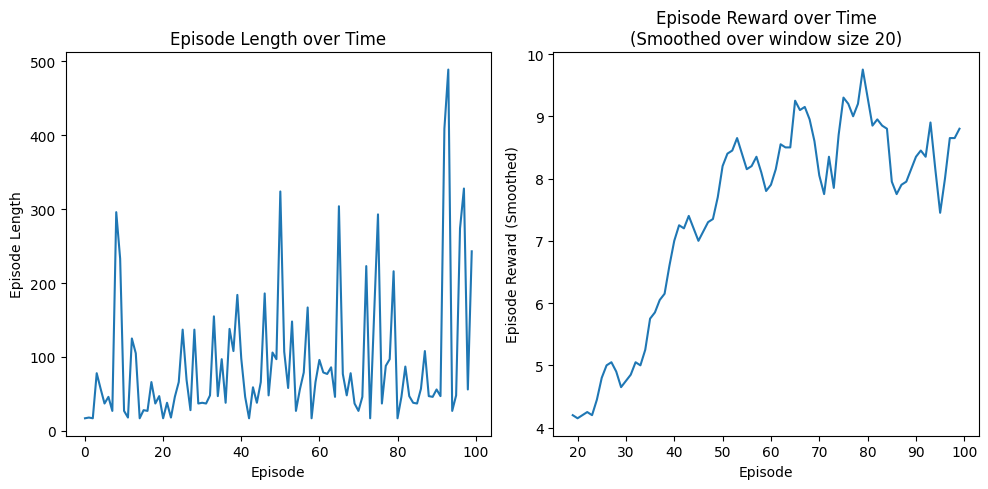

In [ ]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

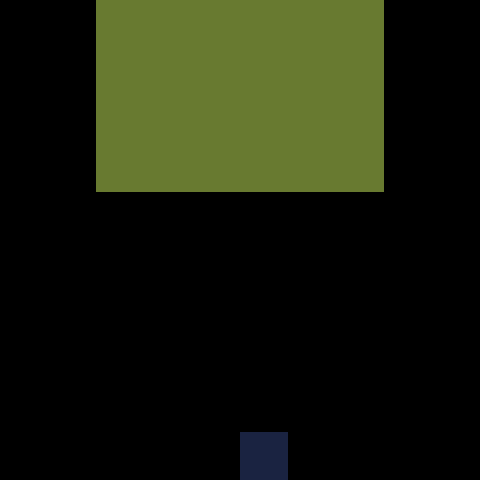

In [ ]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")